In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import kapre
import keras
import os
import soundfile as sf
import time
import progressbar
import gc
import h5py

Using TensorFlow backend.


In [2]:
# Load metadata to extract labels
metadata = pd.read_csv('/data/musicnet/metadata.csv')

In [3]:
metadata.head()

,id,composer,composition,movement,ensemble,source,transcriber,catalog_name,seconds
0,1727,Schubert,Piano Quintet in A major,2. Andante,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,447
1,1728,Schubert,Piano Quintet in A major,3. Scherzo: Presto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,251
2,1729,Schubert,Piano Quintet in A major,4. Andantino - Allegretto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,444
3,1730,Schubert,Piano Quintet in A major,5. Allegro giusto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,368
4,1733,Schubert,Piano Sonata in A major,2. Andantino,Solo Piano,Museopen,Segundo G. Yogore,D959,546


In [4]:
# Construct a dictionary id --> composer, which will be used later to set the labels for all sound snippets
composers = pd.Series(metadata.composer.values,index=metadata.id).to_dict()
examples = [1755, 2211, 2368]
[composers.get(example) for example in examples]

['Schubert', 'Bach', 'Beethoven']

In [5]:
# Creating dataset
# First we define a function to load the audio snippets and to create the labels
def load_audio(path, downsampling_rate, duration_sec, composers):
        '''Requires the soundfile package, imported as sf '''
        files = os.listdir(path)
        message = "Processing {0} audio files...".format(len(files))
        print(message)
        message = "Downsampling dataset to {0}% (equivalent to {1} audio files).".format(downsampling_rate*100, int(downsampling_rate * len(files)) )
        print(message)
        
        ds = np.random.choice(files, int(len(files) * downsampling_rate), replace=False)
        
        # Initialise empty arrays
        data = np.zeros((len(ds), 1, 88200))
        labels = np.zeros(len(ds), dtype = "<U10")
        
        with progressbar.ProgressBar(max_value=len(ds)) as bar:
            
            for i, file in enumerate(ds):
                # load and process file, then add to array
                audio_clip, sr = sf.read(path + file)
                audio_clip = audio_clip[:int(sr*duration_sec)]
                audio_clip = audio_clip[np.newaxis, :]
                data[i, :audio_clip.shape[0],:audio_clip.shape[1]] = audio_clip
                audio_clip = None
            
                # look up label and add to array
                file_id = file.split("-")[0]
                label = composers[int(file_id)]
                labels[i] = label 
                label = None
                bar.update(i)
            
        return labels, data
        

In [ ]:
# CREATE TRAINING DATASET
training_labels, training_data = load_audio("/data/musicnet/train_chunks/", 1, 2, composers)

In [ ]:
# Turn labels to categorical (one-hot encoding)
training_labels_pd = pd.DataFrame(training_labels)
training_onehot = pd.get_dummies(training_labels_pd)
training_targets = training_onehot.as_matrix()
training_targets.shape

In [ ]:
# Store datasets as hdf5 files
train_data = h5py.File('/data/musicnet/hdf5/train_data.hdf5', 'w')
train_data.create_dataset('data', data=training_data)
train_data.create_dataset('targets', data=training_targets)
train_data.close()

In [ ]:
# Remove variables and release all memory
training_data = None
training_labels = None
training_targets = None
train_data = None
gc.collect()

In [ ]:
# CREATE VALIDATION DATASET
validation_labels, validation_data = load_audio("/data/musicnet/validation_chunks/", 1, 2, composers)

In [ ]:
# Turn labels to categorical (one-hot encoding)
validation_labels_pd = pd.DataFrame(validation_labels)
validation_onehot = pd.get_dummies(validation_labels_pd)
validation_targets = validation_onehot.as_matrix()
validation_targets.shape

In [ ]:
# Store datasets as hdf5 files
val_data = h5py.File('/data/musicnet/hdf5/val_data.hdf5', 'w')
val_data.create_dataset('data', data=validation_data)
val_data.create_dataset('targets', data=validation_targets)
val_data.close()

In [ ]:
# Remove variables and release all memory
validation_data = None
validation_labels = None
validation_targets = None
val_data = None
gc.collect()

In [ ]:
# CREATE TEST DATASET
testing_labels, testing_data = load_audio("/data/musicnet/test_chunks/", 1, 2, composers)

In [ ]:
# Turn labels to categorical (one-hot encoding)
testing_labels_pd = pd.DataFrame(testing_labels)
testing_onehot = pd.get_dummies(testing_labels_pd)
testing_targets = testing_onehot.as_matrix()
testing_targets.shape

In [ ]:
# Store datasets as hdf5 files
test_data = h5py.File('/data/musicnet/hdf5/test_data.hdf5', 'w')
test_data.create_dataset('data', data=testing_data)
test_data.create_dataset('targets', data=testing_targets)
test_data.close()

In [ ]:
# Remove variables and release all memory
testing_data = None
testing_labels = None
testing_targets = None
test_data = None
gc.collect()

In [ ]:
# CONVOLUTIONAL NETWORK

In [6]:
# Define a model whose first layer is a mel-spectrogram (from Kapre)
from keras.models import Sequential
from keras import layers
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

In [7]:
# Code inspired by https://github.com/keunwoochoi/kapre
input_shape = (1, 88200)
sr = 44100

model = Sequential()
# A mel-spectrogram layer
model.add(Melspectrogram(n_dft=512, n_hop=256, input_shape=input_shape,
                         padding='same', sr=sr, n_mels=64,
                         fmin=0.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=False, trainable_fb=False,
                         trainable_kernel=False,
                         name='trainable_stft'))
# Add some white noise
model.add(AdditiveNoise(power=0.2))
# Normalise it per-frequency
model.add(Normalization2D(str_axis='batch')) # or 'channel', 'time', 'batch', 'data_sample'
# Add convolution layers
model.add(layers.Conv2D(16, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(16, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

In [8]:
# Load the training and validation data from hdf5
training = h5py.File('/data/musicnet/hdf5/train_data.hdf5', 'r')
validation = h5py.File('/data/musicnet/hdf5/val_data.hdf5', 'r')

list(training.keys())
training_data = training['data']
training_targets = training['targets']

list(validation.keys())
validation_data = validation['data']
validation_targets = validation['targets']

In [9]:
# Compile model
from keras import optimizers
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
file_path="/home/ubuntu/code/trained_model/music/music-weights-improvement-{epoch:02d}-{val_loss:.4f}-{val_acc:.2f}.hdf5"
tensorboard_path = "/home/ubuntu/code/tensorboard/"

callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='acc', patience=2,),
        keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='val_loss', save_best_only=True,),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8,),
        keras.callbacks.TensorBoard(log_dir=tensorboard_path, batch_size=32,)]

history = model.fit(training_data, 
                    training_targets,
                    epochs = 20,
                    batch_size = 150,
                    callbacks=callbacks_list,
                    validation_data=(validation_data, validation_targets),
                    shuffle=False)

Train on 56449 samples, validate on 2765 samples
Epoch 1/20
56449/56449 [==============================] - 113s 2ms/step - loss: 1.4124 - acc: 0.5656 - val_loss: 2.5782 - val_acc: 0.2025
Epoch 2/20
56449/56449 [==============================] - 110s 2ms/step - loss: 1.2637 - acc: 0.5874 - val_loss: 2.3873 - val_acc: 0.2499
Epoch 3/20
56449/56449 [==============================] - 110s 2ms/step - loss: 1.1707 - acc: 0.6010 - val_loss: 2.3155 - val_acc: 0.2723
Epoch 4/20
56449/56449 [==============================] - 110s 2ms/step - loss: 1.1213 - acc: 0.6122 - val_loss: 2.3514 - val_acc: 0.2741
Epoch 5/20
56449/56449 [==============================] - 110s 2ms/step - loss: 1.0880 - acc: 0.6234 - val_loss: 2.2525 - val_acc: 0.3107
Epoch 6/20
56449/56449 [==============================] - 110s 2ms/step - loss: 1.0569 - acc: 0.6304 - val_loss: 2.2194 - val_acc: 0.3237
Epoch 7/20
56449/56449 [==============================] - 110s 2ms/step - loss: 1.0341 - acc: 0.6359 - val_loss: 2.2458 - v

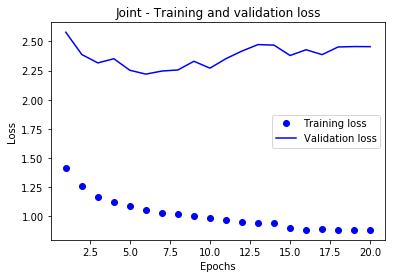

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Total Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Joint - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

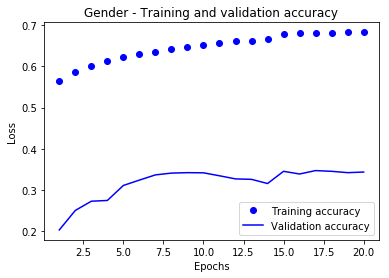

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.subplots(1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Gender - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Do test predictions and compare performance with baseline
test = h5py.File('/data/musicnet/hdf5/test_data.hdf5', 'r')

list(test.keys())
test_data = test['data']
test_targets = test['targets']

In [14]:
training_targets.shape

(56449, 10)

In [15]:
test_predictions = model.predict(test_data)

In [16]:
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_target_labels = np.argmax(test_targets, axis=1)

In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
print('Accuracy ', accuracy_score(test_target_labels, test_predicted_labels))
print(classification_report(test_target_labels, test_predicted_labels))

Accuracy  0.30814441645675905
             precision    recall  f1-score   support

          0       0.66      0.81      0.73       176
          1       0.18      0.90      0.30       268
          2       0.48      0.37      0.42       267
          3       0.56      0.68      0.61       124
          4       1.00      0.00      0.01       740
          5       0.99      0.46      0.63       260
          6       0.00      0.00      0.00       114
          7       0.06      0.18      0.10        89
          8       0.00      0.00      0.00       246
          9       0.32      0.32      0.32        98

avg / total       0.59      0.31      0.25      2382



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
# Compare with baseline classifier (in this case we pick the most popular class)
most_popular = np.argmax(np.bincount(test_target_labels))

In [19]:
baseline_prediction = np.repeat(most_popular, test_target_labels.shape[0])

In [20]:
print('Accuracy ', accuracy_score(test_target_labels, baseline_prediction))
print(classification_report(test_target_labels, baseline_prediction))

Accuracy  0.31066330814441645
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       176
          1       0.00      0.00      0.00       268
          2       0.00      0.00      0.00       267
          3       0.00      0.00      0.00       124
          4       0.31      1.00      0.47       740
          5       0.00      0.00      0.00       260
          6       0.00      0.00      0.00       114
          7       0.00      0.00      0.00        89
          8       0.00      0.00      0.00       246
          9       0.00      0.00      0.00        98

avg / total       0.10      0.31      0.15      2382



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
# Compare with baseline classifier (predicting randomly based on popularity of each class)
unique, counts = np.unique(test_target_labels, return_counts=True)
props = counts / sum(counts)
random_predictions = np.random.choice(10, test_target_labels.shape[0], props.any())

In [22]:
print('Accuracy ', accuracy_score(test_target_labels, random_predictions))
print(classification_report(test_target_labels, random_predictions))

Accuracy  0.09361880772460117
             precision    recall  f1-score   support

          0       0.09      0.11      0.10       176
          1       0.11      0.10      0.11       268
          2       0.10      0.09      0.09       267
          3       0.04      0.07      0.05       124
          4       0.26      0.08      0.13       740
          5       0.11      0.09      0.10       260
          6       0.08      0.17      0.11       114
          7       0.02      0.07      0.04        89
          8       0.07      0.07      0.07       246
          9       0.07      0.15      0.09        98

avg / total       0.14      0.09      0.10      2382

